In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
import seaborn as sns
import requests,json
from tqdm import tqdm
import numpy as np
from geopy.distance import geodesic
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor,RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import functools as ft

# Utils

The method of detecting outliers using box graph

In [2]:
def box_plot_outliers(data_ser, box_scale, col_name):
    """
    :param data_ser: recieve pandas.Series data type
    :param box_scale: the scale of box graph
    """
    iqr = box_scale * (data_ser[col_name].quantile(0.75) - data_ser[col_name].quantile(0.25))
    # Lower threshold
    val_low = data_ser[col_name].quantile(0.25) - iqr*1.5
    # Upper threshold
    val_up = data_ser[col_name].quantile(0.75) + iqr*1.5
    # Outliers
    outlier = data_ser[(data_ser[col_name] < val_low) | (data_ser[col_name] > val_up)]
    # Normal value
    normal_value = data_ser[(data_ser[col_name] > val_low) & (data_ser[col_name] < val_up)]
    return outlier, normal_value, val_low, val_up

Target encoding method.
Target encoding is a very effective method to represent classification columns, and it only occupies one feature space, which is also called mean coding. Each value in this column is replaced by the average target value of this category. This can represent the relationship between the classification variable and the target variable more directly.

In [3]:
def target_encoding(data, target, col_name):
    # Cannot target encoding with test set and too many years as the price is changing. 
    # It may lead to very close value for each category
    year_list_train = [2021,2020]
    data_train = data[data['year'].isin(year_list_train)]
    means = data_train.groupby(col_name)[target].mean()
    temp_data = pd.DataFrame(data)
    temp_data[col_name] = temp_data[col_name].map(means)
    return temp_data[col_name]

The method to split train and test set.<p>We use data between 2009-01 and 2021-12 as our training set and use the data between 2022-01 and 2022-06 as the test set for resale price prediction

In [62]:
def train_test_split(data, target):
    data_train = data[data["year"]<2022]
    data_test = data[data["year"]>=2022]
    X_train = data_train.drop(target, axis=1)
    X_test = data_test.drop(target, axis=1)
    y_train = data_train[target]
    y_test = data_test[target]
    return X_train, X_test, y_train, y_test

Evaluate the model with R2 score and RMSE

In [5]:
def evaluate(model,X_test,y_test):
    y_pre1 = model.predict(X_test)
    print("GradientBoostingRegressor")
    print("r2 score is ", {r2_score(y_test, y_pre1)})
    print("rmse is ", {math.sqrt(mean_squared_error(y_test, y_pre1))})
    print("the price per average square is:", {math.sqrt(mean_squared_error(y_test, y_pre1))/103})

In [6]:
def read_all_resale(price_dir):
    df = None
    for file in [item for item in os.listdir(price_dir) if "csv" in item]:
        temp = pd.read_csv(os.path.join(price_dir,file))
        if df is None:
            df = temp
        else:
            df = pd.concat([df,temp],ignore_index=True)
    return df

In [7]:
def get_loc(addr):
    url = "https://developers.onemap.sg/commonapi/search?"

    common_arg = "&returnGeom=Y&getAddrDetails=Y&pageNum=1"
    query_string='https://developers.onemap.sg/commonapi/search?searchVal='+str(addr)+'&returnGeom=Y&getAddrDetails=Y&pageNum=1'
    resp = requests.get(query_string)

    data = json.loads(resp.content)
    return data["results"]

In [8]:
def get_all_hdb_addr(df_hdb):
    addr_dict = {}
    df_hdb["X"] = np.nan
    df_hdb["Y"] = np.nan
    df_hdb["POSTAL"] = np.nan
    for index, row in tqdm(df_hdb.iterrows()):
        addr = row["addr"]
        actual_loc = {}
        if pd.isna(row["X"]):
            if addr in addr_dict:
                actual_loc = addr_dict[addr]
            else:
                try:
                    loc_data = get_loc(addr)
                except:
                    loc_data = []
                if len(loc_data)!=0:
                    for data in loc_data:
                        if data["BLK_NO"] == str(row["blk_no"]):
                            actual_loc = {"X":str(data["X"]),"Y":str(data["Y"]),"POSTAL":str(data["POSTAL"]),
                                          "LATITUDE":str(data["LATITUDE"]),"LONGITUDE":str(data["LONGITUDE"])}
                            break
                    addr_dict[addr] = actual_loc
            df_hdb.at[index,"X"] = actual_loc.get("X")
            df_hdb.at[index,"Y"] = actual_loc.get("Y")
            df_hdb.at[index,"POSTAL"] = actual_loc.get("POSTAL")
            df_hdb.at[index,"LATITUDE"] = actual_loc.get("LATITUDE")
            df_hdb.at[index,"LONGITUDE"] = actual_loc.get("LONGITUDE")
    return df_hdb

In [9]:
# Reference from https://github.com/teyang-lau/HDB_Resale_Prices/blob/main/get_coordinates.ipynb
def find_nearest(house, amenity, radius=2):
    """
    this function finds the nearest locations from the 2nd table from the 1st address
    Both are dataframes with a specific format:
        1st column: any string column ie addresses taken from the "find_postal_address.py"
        2nd column: latitude (float)
        3rd column: longitude (float)
    Column name doesn't matter.
    It also finds the number of amenities within the given radius (default=2)
    """
    results = {}
    # first column must be address
    for index,flat in enumerate(house.iloc[:,0]):
        
        # 2nd column must be latitude, 3rd column must be longitude
        flat_loc = (house.iloc[index,1],house.iloc[index,2])
        flat_amenity = ['','',100,0]
        for ind, eachloc in enumerate(amenity.iloc[:,0]):
            amenity_loc = (amenity.iloc[ind,1],amenity.iloc[ind,2])
            distance = geodesic(flat_loc,amenity_loc)
            distance = float(str(distance)[:-3]) # convert to float

            if distance <= radius:   # compute number of amenities in 2km radius
                flat_amenity[3] += 1

            if distance < flat_amenity[2]: # find nearest amenity
                flat_amenity[0] = flat
                flat_amenity[1] = eachloc
                flat_amenity[2] = distance

        results[flat] = flat_amenity
    return results

def dist_from_location(house, location):
    """
    this function finds the distance of a location from the 1st address
    First is a dataframe with a specific format:
        1st column: any string column ie addresses taken from the "find_postal_address.py"
        2nd column: latitude (float)
        3rd column: longitude (float)
    Column name doesn't matter.
    Second is tuple with latitude and longitude of location
    """
    results = {}
    # first column must be address
    for index,flat in enumerate(house.iloc[:,0]):
        
        # 2nd column must be latitude, 3rd column must be longitude
        flat_loc = (house.iloc[index,1],house.iloc[index,2])
        flat_amenity = ['',100]
        distance = geodesic(flat_loc,location)
        distance = float(str(distance)[:-3]) # convert to float
        flat_amenity[0] = flat
        flat_amenity[1] = distance
        results[flat] = flat_amenity
    return results

In [10]:
def get_all_dist_var():
    amenities = ['supermarket','school','parks','mall','MRT','dhoby']
    flat_coord = pd.read_csv('./flat_coordinates.csv')
    flat_coord = flat_coord[['address','LATITUDE','LONGITUDE']]
    flat_amenities = None
    count = 0
    for ament in tqdm(amenities):
        if ament == 'dhoby':
            dist_dhoby = dist_from_location(flat_coord, (1.299308, 103.845285))
            ament_df = pd.DataFrame.from_dict(dist_dhoby).T
            ament_df = dist_dhoby.rename(columns={0: 'flat', 1: 'dist_dhoby'}).reset_index().drop(['index'], axis=1)
            
        ament_df = pd.read_csv(ament+'_coordinates.csv')
        ament_df.drop_duplicates(subset=['address'], inplace=True)
        if ament == 'supermarket':
            ament_df = ament_df[['SEARCHVAL','LATITUDE','LONGITUDE']]
        elif ament == 'parks':
            ament_df = ament_df[['index','Y','X']]
        else:
            ament_df = ament_df[['address','LATITUDE','LONGITUDE']]
    
        nearest_ament = find_nearest(flat_coord, ament_df)
        flat_ament = pd.DataFrame.from_dict(nearest_ament).T
        flat_ament = flat_ament.rename(columns={0: 'flat', 1: ament, 2: ament+'_dist', 3: 'num_'+ament+'_2km'}).reset_index().drop('index', axis=1)
        if not count:
            flat_amenities = flat_ament
        else:
            flat_amenities = flat_amenities.merge(flat_ament, on='flat', how='outer')
    flat_amenities.to_csv('./flat_amenities.csv', index=False)
    return flat_amenities
        

# Data Loading and Mining

In [11]:
import os
price_dir = "resale-flat-prices"
data_prices = read_all_resale(price_dir)

In [12]:
data_prices.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [13]:
#root_path = r'D:\semester1\good_dataset\price-and-price-index'
data_hdb = pd.read_csv('HDBPropertyInformation.csv')
data_hdb["addr"] = data_hdb["blk_no"]+" "+data_hdb["street"]
data_prices["addr"] = data_prices["block"]+" "+data_prices["street_name"]

In [17]:
#this one takes too long time, won't show output here
data_hdb = get_all_hdb_addr(data_hdb)
dfs = [data_prices,data_hdb]
df_final = ft.reduce(lambda left, right: pd.merge(left,right, on='addr'),dfs)

12674it [1:26:29,  2.44it/s]


In [26]:
df_final["year"] = df_final["month"].str[:4]
df_final["month"] = df_final["month"].str[5:]
df_final = df_final[df_final.year.astype(int)>2008]
df_final["price_per_sqm"] = df_final["resale_price"]/df_final["floor_area_sqm"]

In [28]:
df_final.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,2room_rental,3room_rental,other_room_rental,X,Y,POSTAL,LATITUDE,LONGITUDE,year,price_per_sqm
0,01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,...,2,0,0,28478.5794445509,39676.8076131288,560174,1.37509746867904,103.83761896123,2015,4250.000000
1,12,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,60.0,Improved,1986,69,...,2,0,0,28478.5794445509,39676.8076131288,560174,1.37509746867904,103.83761896123,2015,4583.333333
2,05,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,69.0,Improved,1986,68,...,2,0,0,28478.5794445509,39676.8076131288,560174,1.37509746867904,103.83761896123,2016,4492.753623
3,06,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4,07 TO 09,45.0,Improved,1986,68,...,2,0,0,28478.5794445509,39676.8076131288,560174,1.37509746867904,103.83761896123,2016,5622.222222
4,11,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,68,...,2,0,0,28478.5794445509,39676.8076131288,560174,1.37509746867904,103.83761896123,2016,4754.098361


In [ ]:
# this is very slow, need to run for 2-3 hours to complete all, as it need to calculate the distance one by one
get_all_dist_var()

In [29]:
#coordinate and distance data for amenties got from https://github.com/teyang-lau/HDB_Resale_Prices/tree/main/Data
flat_amenities = pd.read_csv("flat_amenities.csv")
flat_amenities['addr'] = flat_amenities['flat']

In [31]:
data = pd.read_csv('./house price full2.csv')

In [32]:
data = data.merge(flat_amenities, on='addr', how='left')

In [33]:
data['flat_model'] = data['flat_model'].apply(lambda x: x.upper())

In [34]:
data.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,num_park_2km,mall,mall_dist,num_mall_2km,mrt,mrt_dist,num_mrt_2km,supermarket_dist,num_supermarket_2km,dist_dhoby
0,0,1,HOUGANG,4 ROOM,420,HOUGANG AVE 10,07 TO 09,105.0,MODEL A,1989,...,7.0,Hougang Mall,0.391938,7.0,HOUGANG MRT STATION,0.568975,9.0,0.376531,15.0,10.096472
1,1,1,HOUGANG,4 ROOM,420,HOUGANG AVE 10,01 TO 03,105.0,MODEL A,1989,...,7.0,Hougang Mall,0.391938,7.0,HOUGANG MRT STATION,0.568975,9.0,0.376531,15.0,10.096472
2,2,1,HOUGANG,4 ROOM,420,HOUGANG AVE 10,10 TO 12,105.0,MODEL A,1989,...,7.0,Hougang Mall,0.391938,7.0,HOUGANG MRT STATION,0.568975,9.0,0.376531,15.0,10.096472
3,3,1,HOUGANG,4 ROOM,420,HOUGANG AVE 10,01 TO 03,110.0,MODEL A,1989,...,7.0,Hougang Mall,0.391938,7.0,HOUGANG MRT STATION,0.568975,9.0,0.376531,15.0,10.096472
4,4,1,HOUGANG,5 ROOM,420,HOUGANG AVE 10,10 TO 12,131.0,IMPROVED,1989,...,7.0,Hougang Mall,0.391938,7.0,HOUGANG MRT STATION,0.568975,9.0,0.376531,15.0,10.096472


# Data Exploration

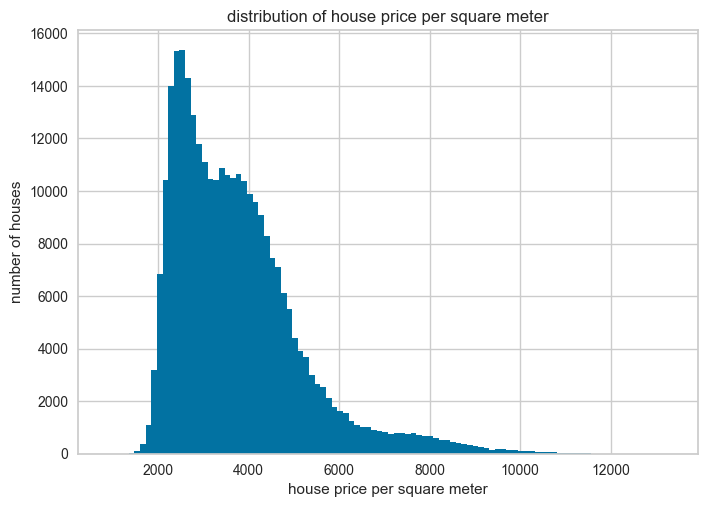

In [35]:
plt.hist(x=data['price_per_sqm'], bins=100)
plt.title('distribution of house price per square meter')
plt.xlabel('house price per square meter')
plt.ylabel('number of houses')
plt.show()

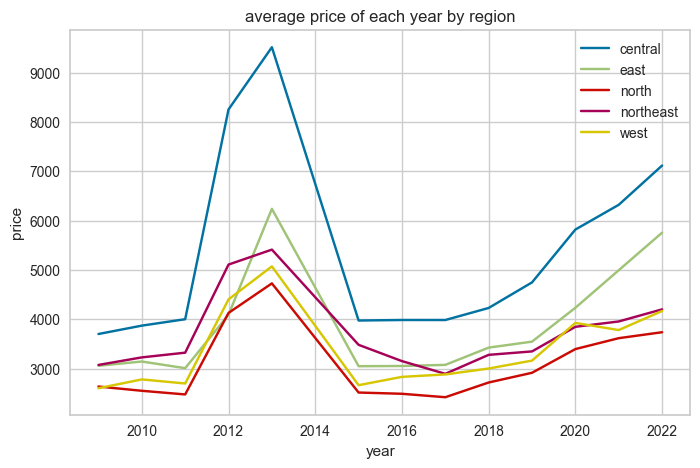

In [36]:
colors = {'northeast':'Purple', 'east':'Green', 'central':'Brown', 'west':'Red', 'north':'Orange'}
town_region = {'HOUGANG': 'northeast', 'JURONG WEST': 'west', 'SERANGOON': 'northeast', 'TAMPINES': 'east',
               'WOODLANDS': 'north', 'YISHUN': 'north', 'BEDOK': 'east', 'BISHAN': 'central', 'BUKIT PANJANG': 'west',
               'BUKIT TIMAH': 'central', 'CHOA CHU KANG': 'west', 'GEYLANG': 'central', 'PASIR RIS': 'east',
               'BUKIT BATOK': 'west', 'JURONG EAST': 'west', 'QUEENSTOWN': 'central', 'TOA PAYOH': 'central',
               'BUKIT MERAH': 'central', 'KALLANG/WHAMPOA': 'central', 'CENTRAL AREA': 'central',
               'ANG MO KIO': 'northeast', 'CLEMENTI': 'west', 'SEMBAWANG': 'north', 'SENGKANG': 'northeast',
               'PUNGGOL': 'northeast', 'MARINE PARADE': 'central'}
tmp = data.copy()
tmp['region'] = tmp['town'].map(town_region)
tmp = tmp.groupby(['region','year'])[['price_per_sqm']].median().reset_index()
#display(tmp)

# Scatterplot with names of towns
fig, ax = plt.subplots(figsize=(8,5))
grouped = tmp.groupby('region')
for key, group in grouped:
    group.plot(ax=ax, kind='line', x='year', y='price_per_sqm', label=key)
plt.title('average price of each year by region')
ax.set_xlabel('Year')
plt.xlabel('year')
plt.ylabel('price')
plt.show()

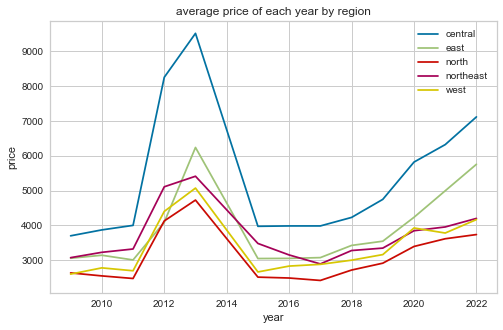

In [1180]:
colors = {'northeast':'Purple', 'east':'Green', 'central':'Brown', 'west':'Red', 'north':'Orange'}
town_region = {'HOUGANG': 'northeast', 'JURONG WEST': 'west', 'SERANGOON': 'northeast', 'TAMPINES': 'east',
               'WOODLANDS': 'north', 'YISHUN': 'north', 'BEDOK': 'east', 'BISHAN': 'central', 'BUKIT PANJANG': 'west',
               'BUKIT TIMAH': 'central', 'CHOA CHU KANG': 'west', 'GEYLANG': 'central', 'PASIR RIS': 'east',
               'BUKIT BATOK': 'west', 'JURONG EAST': 'west', 'QUEENSTOWN': 'central', 'TOA PAYOH': 'central',
               'BUKIT MERAH': 'central', 'KALLANG/WHAMPOA': 'central', 'CENTRAL AREA': 'central',
               'ANG MO KIO': 'northeast', 'CLEMENTI': 'west', 'SEMBAWANG': 'north', 'SENGKANG': 'northeast',
               'PUNGGOL': 'northeast', 'MARINE PARADE': 'central'}
tmp = data.copy()
tmp['region'] = tmp['town'].map(town_region)
tmp = tmp.groupby(['region','year'])[['price_per_sqm']].median().reset_index()
#display(tmp)

# Scatterplot with names of towns
fig, ax = plt.subplots(figsize=(8,5))
grouped = tmp.groupby('region')
for key, group in grouped:
    group.plot(ax=ax, kind='line', x='year', y='price_per_sqm', label=key)
plt.title('average price of each year by region')
ax.set_xlabel('Year')
plt.xlabel('year')
plt.ylabel('price')
plt.show()

Can see there is a clear difference between central and other groups

for different room type the price_per_sqm is not very different

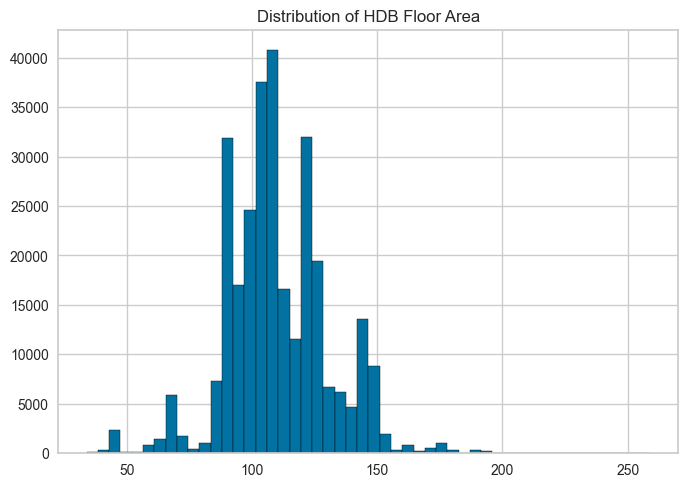

flat_model
PREMIUM MAISONETTE    7
MAISONETTE            6
APARTMENT             4
TERRACE               2
Name: count, dtype: int64

In [37]:
plt.hist(data['floor_area_sqm'], bins=50, edgecolor='black')
plt.title('Distribution of HDB Floor Area')
plt.show()
display(data[data['floor_area_sqm'] > 200]['flat_model'].value_counts())

floor area is normal distributed

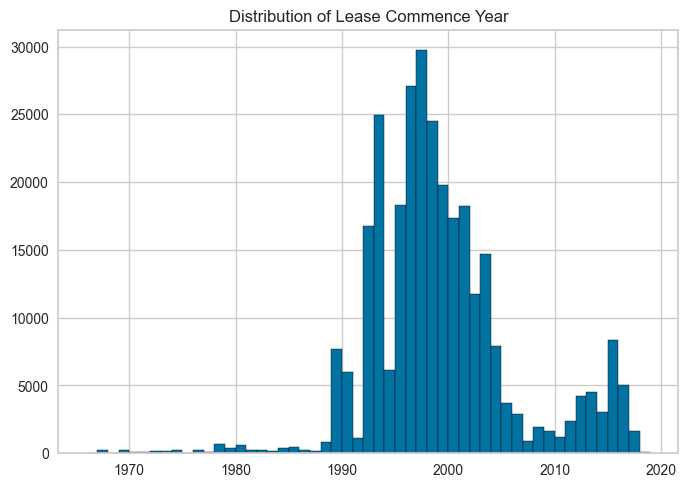

In [38]:
bins = data['lease_commence_date'].max() - data['lease_commence_date'].min()
plt.hist(data['lease_commence_date'], bins=bins, edgecolor='black')
plt.title('Distribution of Lease Commence Year')
plt.show()

lease_commence_date is a bit right shifted

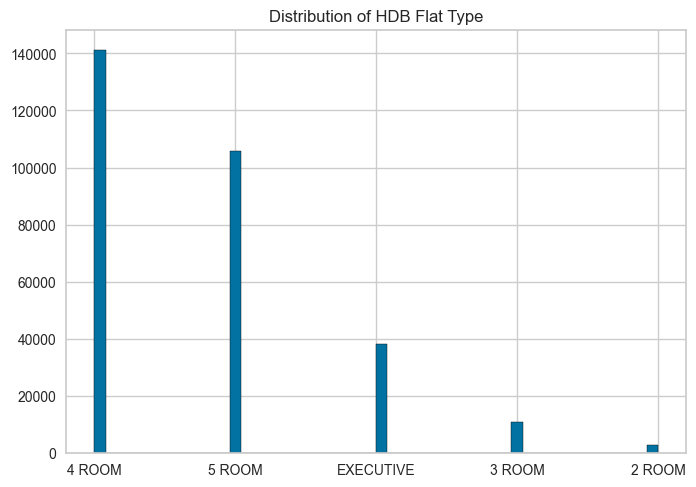

In [39]:
plt.hist(data['flat_type'], bins=50, edgecolor='black')
plt.title('Distribution of HDB Flat Type')
plt.show()

mainly are 4 and 5 Room

C:\Users\Asus\AppData\Local\Temp\ipykernel_27100\1887654943.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


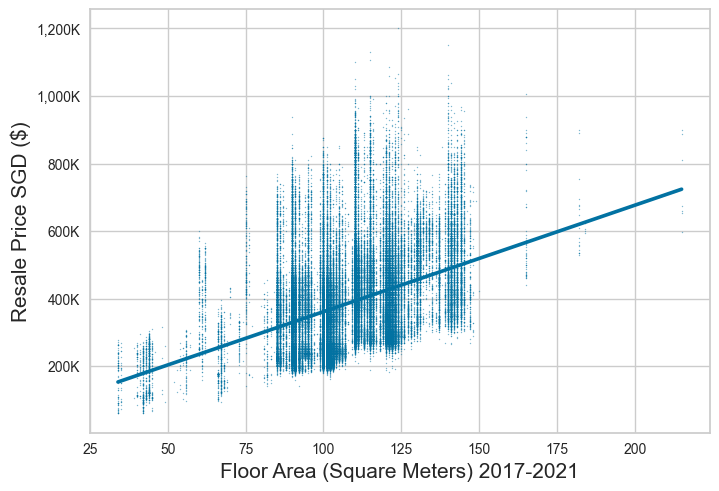

In [40]:
area = data[data['year'].isin([2017,2018,2019,2020,2021])]
p=sns.regplot(x='floor_area_sqm', y='resale_price', data=area, scatter_kws={"s": 1, 'alpha':0.5})
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
p.set_xlabel('Floor Area (Square Meters) 2017-2021', size=15)
plt.show()

Price has clear linear relationship with floor area

C:\Users\Asus\AppData\Local\Temp\ipykernel_27100\1871997353.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


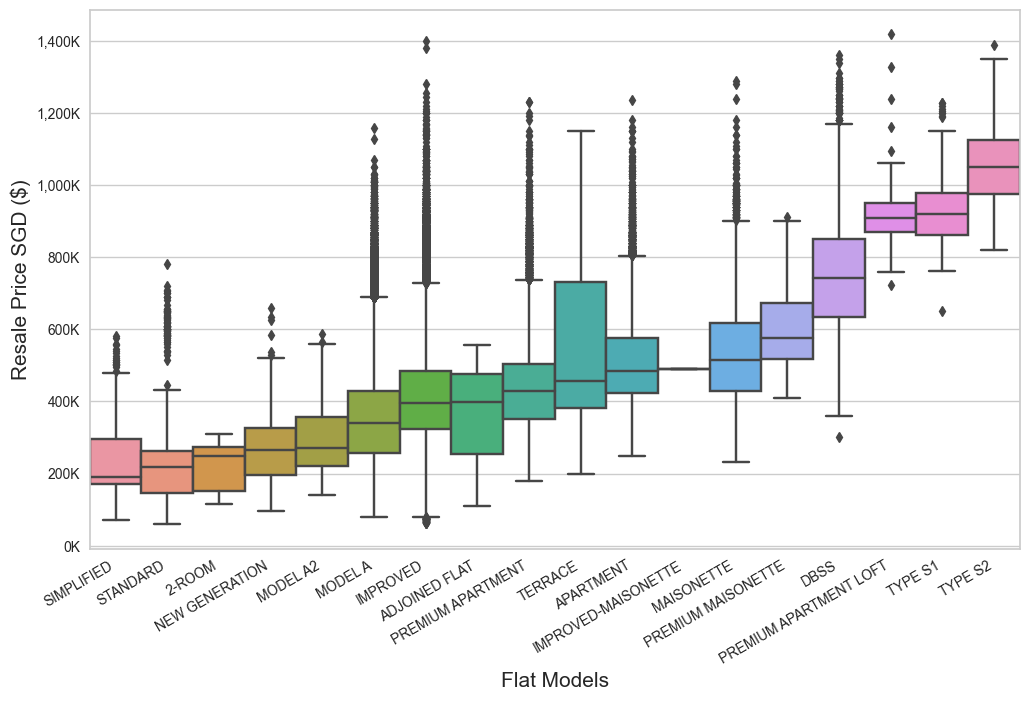

In [41]:
fig = plt.figure(figsize=(12,7))
p=sns.boxplot(x='flat_model', y='resale_price', data=data, width=1,
                order=data.groupby('flat_model')['resale_price'].median().sort_values().reset_index()['flat_model'].tolist())
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right'), p.set_xlabel('Flat Models', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
plt.show()

price for flat models is distinct

C:\Users\Asus\AppData\Local\Temp\ipykernel_27100\2121643520.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_yticklabels(ylabels)


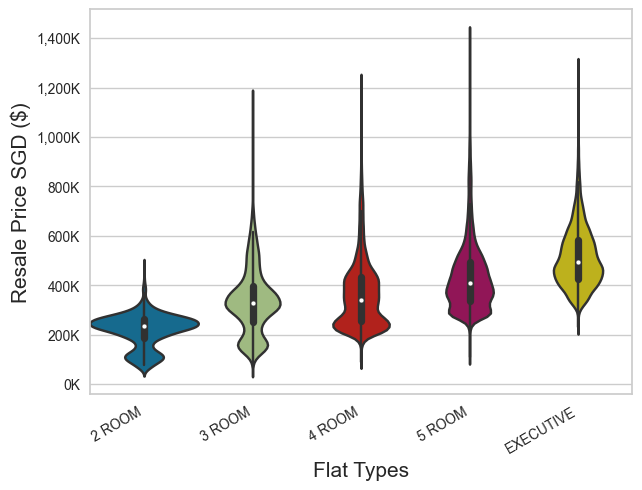

In [42]:
fig = plt.figure(figsize=(7,5))
p=sns.violinplot(x='flat_type', y='resale_price', data=data, width=1,
                order=data.groupby('flat_type')['resale_price'].median().sort_values().reset_index()['flat_type'].tolist())
p.set_xticklabels(p.get_xticklabels(), rotation=30, ha='right'), p.set_xlabel('Flat Types', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in p.get_yticks()/1000]
p.set_yticklabels(ylabels)
p.set_ylabel('Resale Price SGD ($)', size=15)
plt.show()

3 room and 4 room are quite similar but others can be easily differentiated

AttributeError: 'Series' object has no attribute 'append'

<Figure size 1200x400 with 0 Axes>

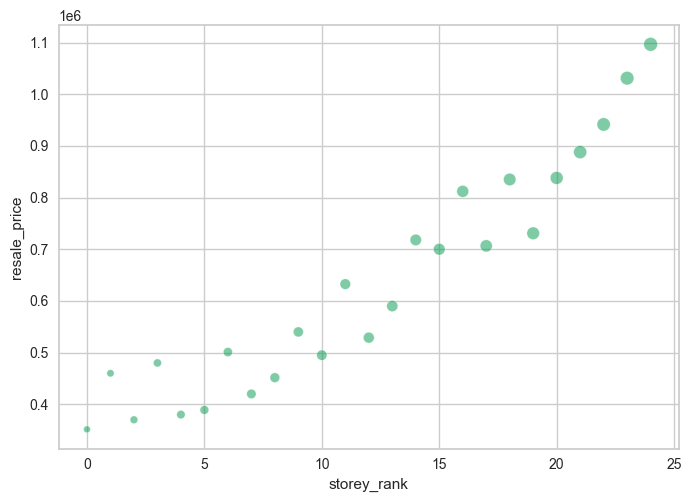

In [45]:
fig = plt.figure(figsize=(12,4))
# Storey Prices
_, ax = plt.subplots()
storey = data.groupby('storey_range')['resale_price'].median().reset_index().sort_values(by='storey_range')
storey['storey_rank'] = storey['storey_range'].astype('category').cat.codes # label encode
a=sns.scatterplot(x=storey['storey_rank'], y=storey['resale_price'], size=storey['storey_rank'].astype('int')*30, color='#00994d', edgecolors='w', alpha=0.5, legend=False,ax=ax)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in a.get_yticks()/1000]
ax.set_xticklabels(pd.Series(['']).append(storey.iloc[[0,5,10,15,20,24],0]))
ax.set_yticklabels(ylabels)
plt.ylim([280000,1100000]), ax.set_ylabel('Resale Price SGD ($)', size=15), ax.set_xlabel('Storey', size=15)
plt.title('2009-2022', size=15)
plt.show()

Higher storey has higher price

C:\Users\Asus\AppData\Local\Temp\ipykernel_27100\2606756015.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels), ax.set_ylabel('Resale Price SGD ($)', size=15)


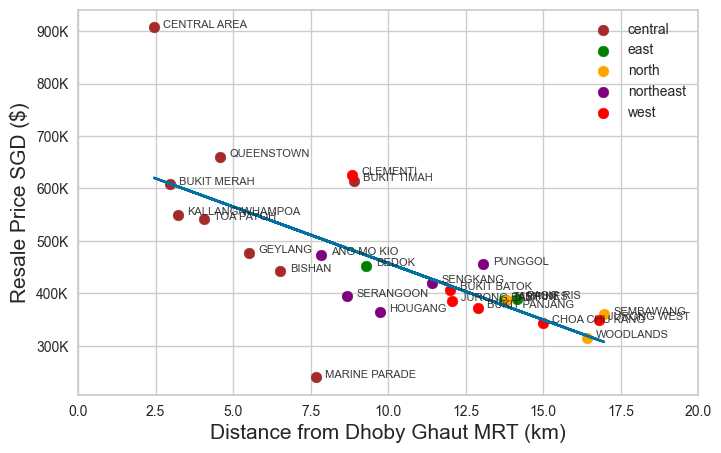

In [46]:
colors = {'northeast':'Purple', 'east':'Green', 'central':'Brown', 'west':'Red', 'north':'Orange'}
town_region = {'HOUGANG': 'northeast', 'JURONG WEST': 'west', 'SERANGOON': 'northeast', 'TAMPINES': 'east',
               'WOODLANDS': 'north', 'YISHUN': 'north', 'BEDOK': 'east', 'BISHAN': 'central', 'BUKIT PANJANG': 'west',
               'BUKIT TIMAH': 'central', 'CHOA CHU KANG': 'west', 'GEYLANG': 'central', 'PASIR RIS': 'east',
               'BUKIT BATOK': 'west', 'JURONG EAST': 'west', 'QUEENSTOWN': 'central', 'TOA PAYOH': 'central',
               'BUKIT MERAH': 'central', 'KALLANG/WHAMPOA': 'central', 'CENTRAL AREA': 'central',
               'ANG MO KIO': 'northeast', 'CLEMENTI': 'west', 'SEMBAWANG': 'north', 'SENGKANG': 'northeast',
               'PUNGGOL': 'northeast', 'MARINE PARADE': 'central'}
tmp = data.groupby('town')[["hawker_dist", "mrt_dist",'dist_dhoby','resale_price']].median().reset_index()
tmp['region'] = tmp['town'].map(town_region)

# Scatterplot with names of towns
fig, ax = plt.subplots(figsize=(8,5))
grouped = tmp.groupby('region')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='dist_dhoby', y='resale_price', label=key, color=colors[key], s=60)
b, a = np.polyfit(tmp['dist_dhoby'], tmp['resale_price'], 1)
ax.plot(tmp['dist_dhoby'], a + b* tmp['dist_dhoby'], '-')  
ax.set_xlim([0,20]), ax.set_xlabel('Distance from Dhoby Ghaut MRT (km)', size=15)
ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels), ax.set_ylabel('Resale Price SGD ($)', size=15)
for i, txt in enumerate(tmp['town']):
    ax.annotate(txt, (tmp['dist_dhoby'][i]+0.3, tmp['resale_price'][i]), size=8, alpha=0.9)

plt.show()

Price is clearly decreasing when it is far away from central area

D:\conda\envs\myenv1\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Asus\AppData\Local\Temp\ipykernel_27100\450646163.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
C:\Users\Asus\AppData\Local\Temp\ipykernel_27100\450646163.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])


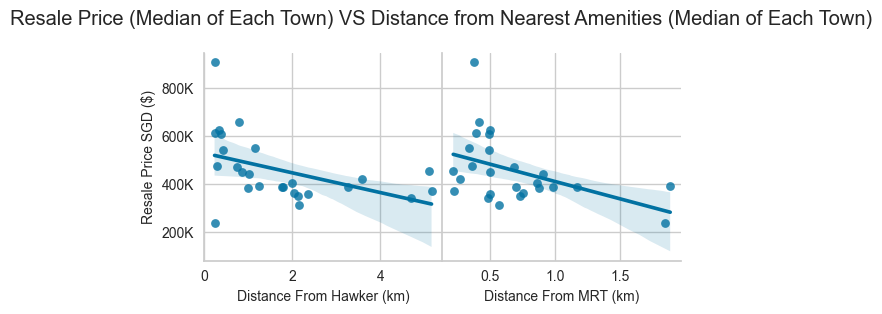

In [47]:
tmp.groupby('region')['resale_price'].median()
p=sns.pairplot(tmp, x_vars=[ "hawker_dist", "mrt_dist"], y_vars=["resale_price"], height=3, aspect=1, kind="reg", plot_kws=dict(scatter_kws=dict(s=40)))
axes=p.axes
ylabels = ['{:,.0f}'.format(x) + 'K' for x in axes[0,0].get_yticks()/1000]
axes[0,0].set_yticklabels(ylabels), axes[0,0].set_ylabel('Resale Price SGD ($)', size=10)
axes[0,0].set_xlabel('Distance From Hawker (km)', size=10)
axes[0,1].set_xlabel('Distance From MRT (km)', size=10)
plt.suptitle('Resale Price (Median of Each Town) VS Distance from Nearest Amenities (Median of Each Town)')
plt.tight_layout(pad=0, rect=[0, 0, 0.9, 0.9])
plt.show()

price is also decreasing but not significant when distance from mrt and hawker is increasing

# Feature Engineering

## Data Cleaning
Removing some repeated features manually. <p> Since feature 'addr' contains information of 'blk_no', 'street','block', 'street_name',We only use 'addr' for our detailed location <p> The feature 'remaining_lease' has no value, so just delete it. <p> The feature '1room_sold' and 'multigen_sold' has only 1 value, so we ignore them in our analysis.<p>The feature 'other_room_rental' does not pass the KruskalWallis test, with a high p value of 0.84, so we also delete this feature

In [48]:
drop_columns = ['Unnamed: 0','price_per_sqm','blk_no','street_name',
            'remaining_lease','1room_sold','multigen_sold','other_room_rental',
            'flat']
data = data.drop(drop_columns,axis =1)

## Correlation Check

C:\Users\Asus\AppData\Local\Temp\ipykernel_27100\534622053.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


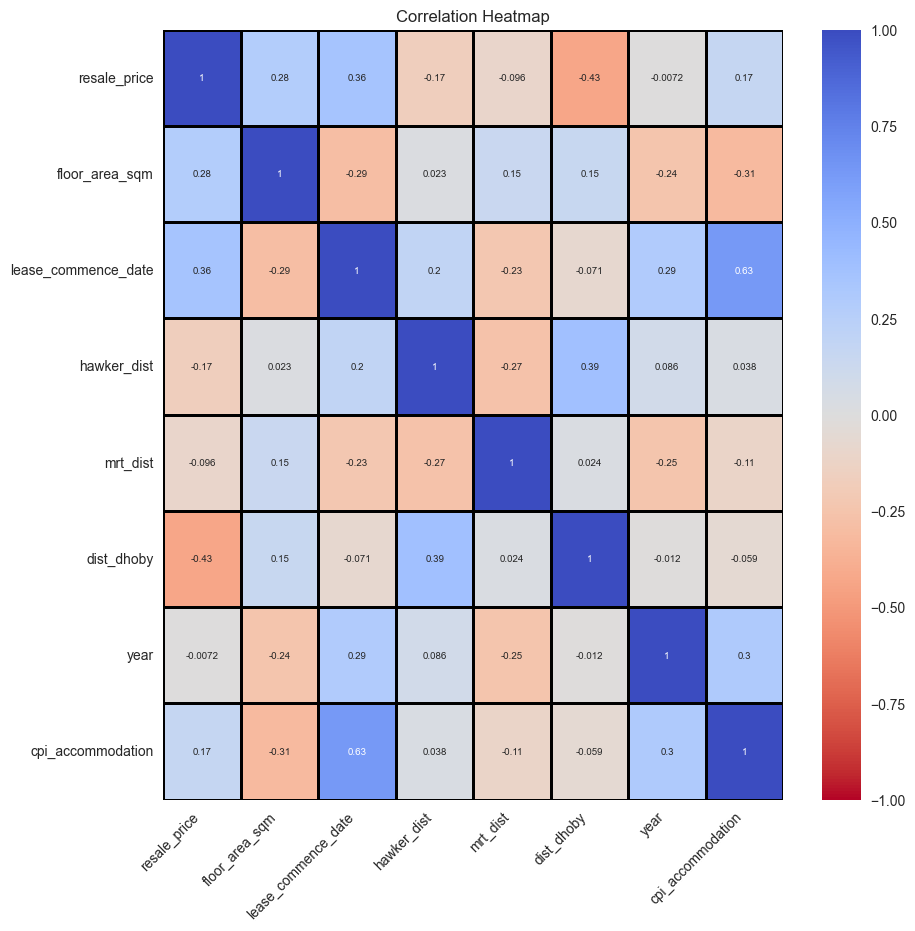

In [49]:
#We did for all columns, but here for better visualization just show some significant value
correlation_df = data[["resale_price","floor_area_sqm","lease_commence_date","hawker_dist","mrt_dist","dist_dhoby","year","cpi_accommodation"]]
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(correlation_df.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()

## House price inflation adjustment

In [50]:
adjustment_list = ['cpi_accommodation','non_landed_rest_of_central_region_residential_rindex','cpi_private_transport']
average_adjust_index = (data['cpi_accommodation'].mean()+data['cpi_private_transport'].mean() + data['non_landed_rest_of_central_region_residential_rindex'].mean())/300
data["resale_price_init"] = data['resale_price']
data['resale_price'] = (data['resale_price'] / (data['cpi_accommodation']+data['cpi_private_transport'] +
                                                data['non_landed_rest_of_central_region_residential_rindex'])) *3 * 100

data = data.drop(adjustment_list, axis=1)
print(average_adjust_index)

1.0261330918068399


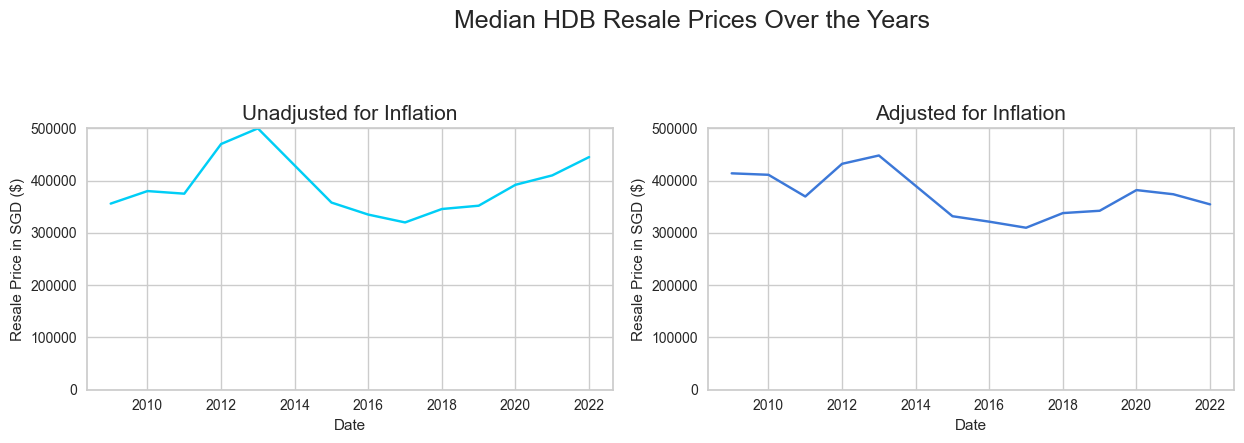

In [51]:

# Unadjusted
fig = plt.figure(figsize=(14,4.5))
fig.suptitle('Median HDB Resale Prices Over the Years', fontsize=18)
ax1 = fig.add_subplot(121)
data.sort_values(by=['year']).groupby(['year'])[['resale_price_init']].median().plot(ax=ax1, color='#00cef6', legend=None)
ax1.set_xlabel('Date'), ax1.set_ylabel('Resale Price in SGD ($)'), ax1.set_ylim(0, 500000), ax1.set_title('Unadjusted for Inflation', size=15)

# Adjusted
# https://jakevdp.github.io/PythonDataScienceHandbook/04.09-text-and-annotation.html
ax2 = fig.add_subplot(122)
data.sort_values(by=['year']).groupby(['year'])[['resale_price']].median().plot(ax=ax2, color='#3c78d8', legend=None)
ax2.set_xlabel('Date'), ax2.set_ylabel('Resale Price in SGD ($)'), ax2.set_ylim(0, 500000), ax2.set_title('Adjusted for Inflation',size=15)
plt.tight_layout(rect=[0, 0, 0.9, 0.9]) 

plt.show()


MAS announced new cooling measure measures effective from **12 January 2013**. This include higher buyer’s stamp duty, lower loan to value financing quantum, increased cash down payment for second mortgages onwards and a NEW introduction of seller’s stamp duty for industrial properties. \
The Singapore CPI also has shown increasing inflation pressures during the first half of 2022. The CPI reading for May 2022 showing an increase of 5.6%. \
We can see the adjustment did a good scale down for explosion before 2013 and for 2022 first half

## Data Restructure and Encoding
For feature 'flat_type', we only keep '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', because the rest is so few in scale.<p>
    Then we perform label encoding on this feature

In [52]:
room_type = ['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE']
data = data[data['flat_type'].isin(room_type)]
flattype_label = {'2 ROOM': 0, '3 ROOM': 1, '4 ROOM': 2, '5 ROOM': 3, 'EXECUTIVE': 4}
data = data.replace({'flat_type': flattype_label})

For the feature 'town', since we already have feature 'addr' for more detailed address, we choose to convert 'town' to the bigger region the house belongs to, because our pre-analysis has shown that region will has a quite big influence on the price

In [53]:
data = data.replace({'town': town_region})
data = data.dropna().reset_index()
data = data.drop('index', axis=1)

feature encoding for the rest of the features. Using target encoding, label encoding, one-hot encoding

In [54]:
#Target encoding
data['flat_model'] = target_encoding(data, 'resale_price', 'flat_model')
data['bldg_contract_town'] = target_encoding(data, 'resale_price', 'bldg_contract_town')
#label encoding
data['storey_range'] = data['storey_range'].apply(lambda x: int(int(x[0:2])/3 + 1))
data['commercial'] = data['commercial'].apply(lambda x: 1 if x=='Y' else 0)
data['miscellaneous'] = data['miscellaneous'].apply(lambda x: 1 if x=='Y' else 0)
data['residential'] = data['residential'].apply(lambda x: 1 if x=='Y' else 0)
data['market_hawker'] = data['market_hawker'].apply(lambda x: 1 if x=='Y' else 0)
data['multistorey_carpark'] = data['multistorey_carpark'].apply(lambda x: 1 if x=='Y' else 0)
data['precinct_pavilion'] = data['precinct_pavilion'].apply(lambda x: 1 if x=='Y' else 0)
#one hot encoding for small class
data = pd.get_dummies(data, columns=['town'], prefix=['region'], drop_first=True)

In this step, we remove abnormal samples with box graph. From the conclusion of pre-visualization of our dataset, we believe the geographic location is one of a key factor in predicting price, so we choose to use coordinates ‘X’ and ‘Y’ to detect outliers and remove all outlier samples. ‘floor_area_sqm’ is also a chosen feature in detecting outliers, as we think some rare houses with very small or large area may also affect the final performance of the model.

In [55]:
print('The length of data before removing outlier:', {len(data)})
featureToConsider = ['X', 'Y', 'floor_area_sqm']
for col in featureToConsider:
    data_out, data, val_low, val_up = box_plot_outliers(data, 2, col)
print('The length of data after removing outlier:',{len(data)})

The length of data before removing outlier: {291660}
The length of data after removing outlier: {290986}


## clean up the rest non-important information

In [56]:
data = data.drop(["X","Y","POSTAL",'resale_price_init',
                 'mrt','school','mall','hawker','addr'],axis=1)
data = data.drop(['block','street'],axis=1)

# Data Preparation

Drop samples with missing value. As there are in total about 800 samples that have missing value, compared to the total around 300000 samples for the whole dataset, the influence is negligible， so just remove them

In [57]:
# XGBoost can accept nan data, below is for GradientBoostingRegressor and RandomForest
data = data.dropna().reset_index()
data = data.drop('index', axis=1)

split train, test dataset

In [59]:
data

,month,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,max_floor_lvl,year_completed,residential,...,num_mall_2km,mrt_dist,num_mrt_2km,supermarket_dist,num_supermarket_2km,dist_dhoby,region_east,region_north,region_northeast,region_west
0,1,2,3,105.0,368658.987146,1989,277657.167668,13,1988,1,...,7.0,0.568975,9.0,0.376531,15.0,10.096472,False,False,True,False
1,1,2,1,105.0,368658.987146,1989,266230.946777,13,1988,1,...,7.0,0.568975,9.0,0.376531,15.0,10.096472,False,False,True,False
2,1,2,4,105.0,368658.987146,1989,292511.254828,13,1988,1,...,7.0,0.568975,9.0,0.376531,15.0,10.096472,False,False,True,False
3,1,2,1,110.0,368658.987146,1989,268516.190955,13,1988,1,...,7.0,0.568975,9.0,0.376531,15.0,10.096472,False,False,True,False
4,1,3,4,131.0,417212.565817,1989,361068.580178,13,1988,1,...,7.0,0.568975,9.0,0.376531,15.0,10.096472,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228588,11,3,6,113.0,417212.565817,2017,538827.164688,18,2015,1,...,6.0,0.213342,19.0,0.410846,16.0,12.178370,False,False,True,False
228589,11,3,2,113.0,417212.565817,2017,500719.322448,18,2015,1,...,6.0,0.213342,19.0,0.410846,16.0,12.178370,False,False,True,False
228590,11,2,5,93.0,368658.987146,2017,425389.866859,18,2015,1,...,6.0,0.213342,19.0,0.410846,16.0,12.178370,False,False,True,False
228591,11,3,2,113.0,417212.565817,2017,514012.755788,18,2015,1,...,6.0,0.213342,19.0,0.410846,16.0,12.178370,False,False,True,False


In [63]:
X_train, X_test, y_train, y_test = train_test_split(data, 'resale_price')

This following shows the average floor area of all houses remianed in our testset

In [66]:
print("avg area: ")
print(X_test['floor_area_sqm'].sum()/len(X_test))

avg area: 
102.85991182730314


# Model Training

## Code for Grid Search -  XGBoost

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth':hp.quniform('max_depth', 1, 10, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBRegressor(tree_method="gpu_hist",
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']),min_child_weight=int(space['min_child_weight']),
                    early_stopping_rounds=5)
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(x_test)
    rmse = np.sqrt(MSE(y_test, pred))
    return {'loss': rmse, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

## Try with three models
Model training stage, GradientBoostingRegressor gives the best result so far. With a r2 score of 0.681, and the average prediciton error for each hosue in 2022 is , and the price error per squre meter is .

In [70]:
model1 = GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
                                  n_estimators=500).fit(X_train, y_train)
# model2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=1,
#                                                                min_samples_split=2), n_estimators=200,
#                            loss='exponential', learning_rate=0.01).fit(X_train, y_train)
y_pre1 = model1.predict(X_test)
# y_pre2 = model2.predict(X_test)
print("GradientBoostingRegressor")
evaluate(model1,X_test,y_test)

GradientBoostingRegressor
GradientBoostingRegressor
r2 score is  {0.5514644688666567}
rmse is  {64447.06332970039}
the price per average square is: {625.6996439776736}


GradientBoostingRegressor \
r2 score is  {0.5507731887141238} \
rmse is  {64496.70691473586} \
the price per average square is: {626.1816205314161}

In [71]:
#model3 = DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=1, min_samples_split=2).fit(X_train, y_train)
model4 = RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100).fit(X_train, y_train)
#y_pre1 = model3.predict(X_test)
y_pre2 = model4.predict(X_test)
# print("DecisionTreeRegressor")
# print("r2 score is ", {r2_score(y_test, y_pre1)})
# print("rmse is ", {math.sqrt(mean_squared_error(y_test, y_pre1))})
# print("the price per average square is:", {math.sqrt(mean_squared_error(y_test, y_pre1))/103})
# print("=================================================================")
print("RandomForestRegressor")
evaluate(model4,X_test,y_test)

RandomForestRegressor
GradientBoostingRegressor
r2 score is  {0.5189998594309012}
rmse is  {66738.63323553307}
the price per average square is: {647.9478954906123}


RandomForestRegressor \
r2 score is  {0.4740276766333603} \
rmse is  {69788.86781017063} \
the price per average square is: {677.5618233997149} \

In [72]:
import xgboost as xgb
reg = xgb.XGBRegressor(tree_method="gpu_hist", early_stopping_rounds=3,n_estimators=100, max_depth=7, min_child_weight=6,learning_rate=0.1)
reg.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:339801.26695
[1]	validation_0-rmse:305384.76645
[2]	validation_0-rmse:273184.72899
[3]	validation_0-rmse:245395.78667
[4]	validation_0-rmse:219389.40601
[5]	validation_0-rmse:196788.37987
[6]	validation_0-rmse:176855.20451
[7]	validation_0-rmse:158922.49708
[8]	validation_0-rmse:142990.60109
[9]	validation_0-rmse:128703.66410
[10]	validation_0-rmse:116423.15736
[11]	validation_0-rmse:106066.84861
[12]	validation_0-rmse:96789.13854
[13]	validation_0-rmse:89090.59951
[14]	validation_0-rmse:82337.75018
[15]	validation_0-rmse:76358.71351
[16]	validation_0-rmse:71634.90463
[17]	validation_0-rmse:67793.84398
[18]	validation_0-rmse:64710.73965
[19]	validation_0-rmse:62506.82539
[20]	validation_0-rmse:60840.17444
[21]	validation_0-rmse:59781.78461
[22]	validation_0-rmse:59043.77756
[23]	validation_0-rmse:58605.75674
[24]	validation_0-rmse:58359.83193
[25]	validation_0-rmse:58331.39682
[26]	validation_0-rmse:58459.11839
[27]	validation_0-rmse:58654.26284


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=3,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [73]:
print("Xgboost")
evaluate(reg,X_test,y_test)

Xgboost
GradientBoostingRegressor
r2 score is  {0.6325524600669594}
rmse is  {58331.397149967}
the price per average square is: {566.3242441744369}


# Conclusion

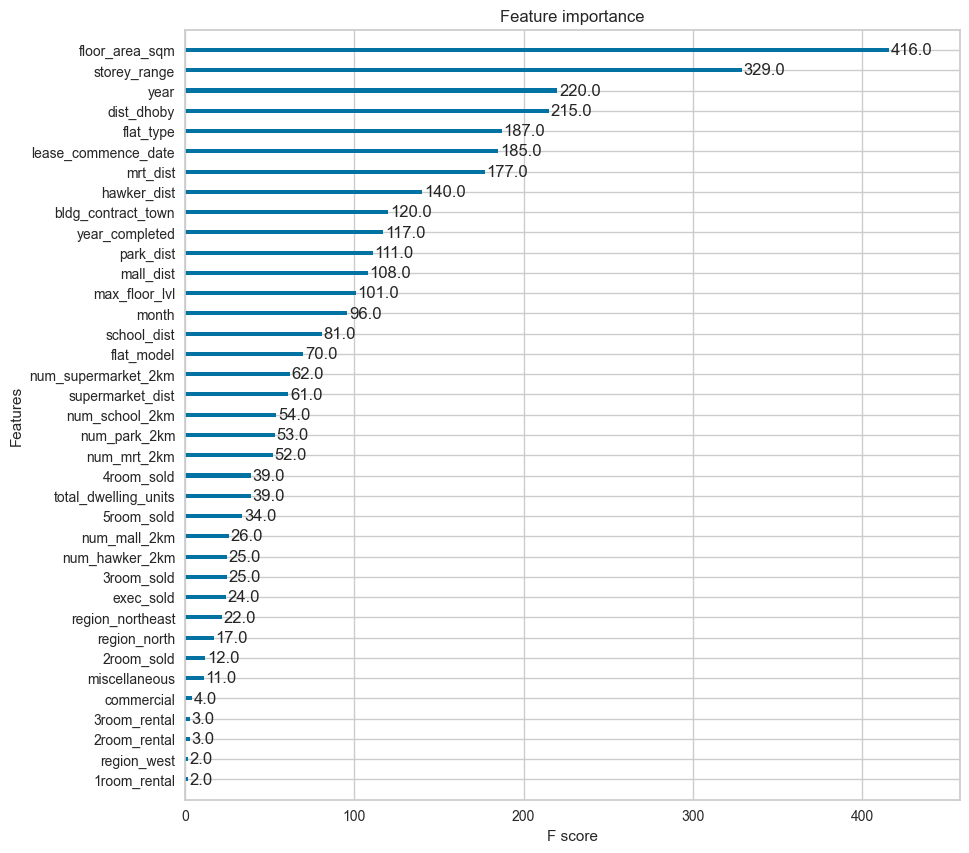

In [74]:
ax = xgb.plot_importance(reg)
fig = ax.figure
fig.set_size_inches(10, 10)

As is shown, the area and floor
level are the most crucial factors in the predictions of house prices. The effect of year for sale, the distance
to downtown area, the date of lease commences of houses, the flat type, and the distance to the closest
hawker and mrt are also considered as influential features

The prediction of housing prices could be an important reference to the estimation of purchasing power for
those who want to buy houses in the future 1 or 2 years. Our optimal model shows a prediction error of 561
SGD per square metre. Though the prediction might not be quite precise, the model stills show a superior
performance and gives a rough estimation of the housing price, which might also be helpful.
The prediction of actual housing price will never be an easy problem because there are so many hidden
variables that we do not consider as features. For example, even the seller's personal wish will also the
change of a single house price, but this factor is difficult to consider in machine learning processing. In the
future work, adding more features that concern more economic factors and other data related to people's
livelihoods with a robust model will further decrease the prediction error.